# Exploring Deforestation with Python
---

**<font color='red'>FYI If unable to install rioxarray but have access to PIL, numpy, and matplotlib, follow the alternative code steps in blue text where available. Where they exist, the outputs of the alternative workflow are often the same as the main workflow, but will noticeably lack any geospatial references.</font>**

---

**Which example of Deforestation are we examining?**    
Change from 1984 to 2022 in a 60 square km region of interest (ROI) originally covered mainly by tropical dry forest at the Brazil-Bolivia border within the Amazon River basin. 
    
More context available from NASA's "Mapping the Amazon" series, which happens to feature the wider ROI -> https://earthobservatory.nasa.gov/images/145649/mapping-the-amazon

**What scientific approaches are we taking?**    
Satellite image processing and classification (hand-crafted/experimental)

**What outputs will we develop?**       
Spectral vegetation indices (NDVI) and thematic maps (Land Cover).

**What will our outputs tell us?**    
Help quantitatively detect and measure Land Cover and Land Use (LCLU) change in this ROI, particularly the clearance of original tropical dry forest since 1984.

**Beyond the well-known Eco impacts of Deforestation, what makes this example significant?**      
Exemplifies the contrasting historical LCLU change in a biome as a consequence of country boundaries and local differences, e.g. in Forest Governance, Stewardship etc.      
Possible view of the ROI at ground-level -> https://andrebaertschi.photoshelter.com/image/I0000Nax5X69EnEA

Can highlight issues of REDD project efficacy (Reducing Emissions From Deforestation and Forest Degradation) and carbon offsetting generally. The Noel Kempff Mercado National Park, which takes up a sizeable portion in the bottom-right of the ROI, is part of one of the world's first large-scale REDD projects, receiving investment from 3 energy companies in exchange for rights to apparently 51% of carbon credits generated, and had been accused of significant flaws -> https://www.theguardian.com/environment/2010/mar/11/greenwash-noel-kempff-forests

---
**Data Source - Satellite Imagery**
* Tutorial subfolder: `DeforestationExp_DATA`
* Tutorial files:
    * `ROI_1984_nirband4.tif` - clip of Landsat 5 TM Scene 230/69, Near Infrared Band (B4) (Aug 13th, 1984)
    * `ROI_1984_redband3.tif` - clip of Landsat 5 TM Scene 230/69, Red Band (B3) (Aug 13th, 1984)
    * `ROI_2022_nirband5.tif` - clip of Landsat 9 OLI Scene 230/69, Near Infrared Band (B5)(Aug 14th, 2022)
    * `ROI_2022_redband4.tif` - clip of Landsat 9 OLI Scene 230/69, Red Band (B4) (Aug 14th, 2022)
* Org: The US Geological Survey (USGS)
* Resource: LandsatLook, a portal that allows rapid online viewing and access to the USGS Landsat Collection 2 data -> https://landsatlook.usgs.gov/
---

**Extra info on Spectral Remote Sensing**
* National Ecological Observatory Network (NEON), "Mapping the Invisible - Intro to Spectral Remote Sensing" (short video) -> https://youtu.be/3iaFzafWJQE
* NASA Remote Sensing primer -> https://www.earthdata.nasa.gov/learn/backgrounders/remote-sensing 
* NASA Applied Remote Sensing Training Program (ARSET), Remote Sensing Fundamentals -> https://appliedsciences.nasa.gov/sites/default/files/2022-11/Fundamentals_of_RS_Edited_SC.pdf
---

## A. Set-up Jupyter Notebook & satellite data

>**A0.** Import required packages and submodule.
>```
import glob
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
```

> <font color='blue'>**A0.** Alternative </font>
>```
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
```

In [1]:
import glob
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt

>**A1.** / <font color='blue'>**A1.** Alternative</font> (OPTIONAL) For autocompletion, or if it's not working, try running this magic command.
```
%config Completer.use_jedi = False
```

In [2]:
%config Completer.use_jedi = False

>**A2.** Read-in the 4 Tutorial files in the `DeforestationExp_DATA` subfolder, also creating global variables with the same name as their corresponding filename (i.e. the substring excluding the `.tif` file extension).
>
>**Tech Note:** `masked=True` is passed to rioxarray's `open_rasterio()` method to mask any potential `NoData` values.
>```
path = "DeforestationExp_DATA"
extension = ".tif"
rasters = glob.glob(path + "/*" + extension)
>
>for i in rasters:
    globals()[f'{i[ len(path)+1 : -len(extension) ]}'] = rxr.open_rasterio(i, masked=True).squeeze()
```

> <font color='blue'>**A2.** Alternative</font>      
> <font color='blue'>**ESSENTIAL** to edit the extension of each file to `.tiff` instead of `.tif` in order to be read by PIL `Image.open()`.</font>
>```
path = "DeforestationExp_DATA"
extension = ".tiff"
rasters = glob.glob(path + "/*" + extension)
>
>for i in rasters:   
    globals()[f'{i[ len(path)+1 : -len(extension) ]}'] = np.asarray(Image.open(i), dtype=np.float32)
```

In [3]:
path = "DeforestationExp_DATA"
extension = ".tif"
rasters = glob.glob(path + "/*" + extension)

for i in rasters:
    globals()[f'{i[ len(path)+1 : -len(extension) ]}'] = rxr.open_rasterio(i, masked=True).squeeze()

---
## B. Inspect the satellite data

<font color="green">***B. Intro***   
*- Raster data is one of two main types of geospatial data. The other is vector data - the points and polygons we handled in the mapping sections of the Carbon Polluters Exploration are examples of this.*    
*- Data stored in raster format are typically in a grid/matrix structure, and render as pixels (picture elements).*      
*- For geospatial raster data, each pixel relates to some area on Earth, and each pixel value is a measurement of some real-world phenomenon.*       
*- The 4 Tutorial files are geospatial raster datasets, and the pixel values they contain are satellite measurements of amounts of light reflected from a single band of the electromagnetic spectrum/defined range of wavelengths, i.e. spectral reflectance values.*    
*- Specifically, each single-band raster contains measurements of either `Red` band or `Near Infrared` (NIR) reflected light.*     

<font color="green">***CAVEAT!! HIGH-LEVEL EXPLORATION ONLY!!***    
*- There are differences in both `Red` and `NIR` band coverage between the two Landsat sources of Tutorial files, Landsat 5 TM and Landsat 9 OLI, which are older and new sensors respectively - see comparison table below for details extracted from the USGS band designation doc -> https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites).*    
    
    
|                     | Red Band Wavelength | NIR Band Wavelength |
| ------------------- | -------------|---------------|
|  Landsat 5 TM|  0.63 - 0.69 |  0.76 - 0.90  |
|  Landsat 9 OLI|  0.64 - 0.67 |  0.85 - 0.88  |
    
    
<font color="green">*- As the two sensors have not, therefore, collected like-for-like data, expect some limitation on the comparability of data outputs derived from these different sources.*

>**B0.** / <font color='blue'>**B0.** Alternative</font> Check the dimensions of any of the 4 Tutorial rasters, i.e. `ROI_1984_redband3`, `ROI_1984_nirband4`, `ROI_2022_redband4`, or `ROI_2022_nirband5`.
>
>**Tech Note:** The original Tutorial GeoTIFF files has 3 dimensions, i.e. (<no. of bands>, <no. of rows>, <no. of columns>). However given single-band rasters the band dimension has length 1, this dimension has been removed in A2. through the `squeeze()` call.
>```
ROI_1984_redband3.shape
```

>**B1.** / <font color='blue'>**B1.** Alternative</font> Check the `dtype` of any of the Tutorial rasters.
>
>**Tech Note:** The original data downloaded from LandsatLook has the `dtype` `uint16`. The read-in Tutorial rasters are now `floats` as a result of specifying `NoData` values to be masked, i.e. converted to `NaN`. Read more on the raw satellite data, e.g. from here -> https://yceo.yale.edu/how-convert-landsat-dns-top-atmosphere-toa-reflectance
>```
ROI_1984_redband3.dtype
```

>**B2.** Try rendering the Red band reflectance values of the ROI in 1984 using `plot()`, which, of course, uses matplotlib. Pass `"Reds_r"` as the optional `cmap` argument, and adjust the size and aspect of the plot (to be smaller than the default so as to be faster).
>
>**Tech Note:** The areas where more light was reflected (with higher spectral reflectance values) should be coloured as brighter pixels and vice versa, hence the reversed cmap `"Reds_r"`.
>```
ROI_1984_redband3.plot(cmap="Reds_r", aspect=1.3, size=4)
```

> <font color='blue'>**B2.** Alternative</font>  
>```
plt.matshow(ROI_1984_redband3, cmap="Reds_r")
```

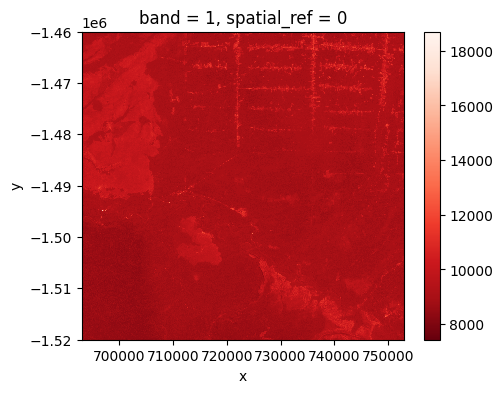

In [4]:
ROI_1984_redband3.plot(cmap="Reds_r", aspect=1.3, size=4)

<font color="green">***B2. Comment***    
*- There is a visible orthogonal pattern that looks like the "Fishbone" Amazon deforestation pattern -> https://landsat.visibleearth.nasa.gov/view.php?id=145888*

>**B3.** / <font color='blue'>**B3.** No Alternative</font> There is a range of spatial metadata embedded in our rasters. Use rioxarray's `bounds()` method to check the spatial extent of any of the rasters. 
>
>**Code Detail:** Result is the outermost coordinates, i.e. corners of the raster in the order (left, bottom, right, top).  
>
>**Tech Note:** Should be close to the values originally used to prepare the clip, i.e. `minx=693000, miny=-1.52e6, maxx=753000, maxy=-1.46e6`, but may not exactly match. (Thoughts why?)   
>```
ROI_1984_redband3.rio.bounds()
```

In [5]:
ROI_1984_redband3.rio.bounds()

(692985.0, -1520025.0, 753015.0, -1459995.0)

>**B4.** Have a look at some actual reflectance values. Extract a sample at the top-left corner of the `ROI_1984_redband3` raster as a numpy subarray, specifically the first 5 rows and 5 columns.    
>
>**Code Detail:** `ROI_1984_redband3`, an xarray `DataArray` data structure, has an attribute `values` that returns it's data as a numpy array.
>```
ROI_1984_redband3.values[:5, :5]    # Reminder that 2D array indexing is in the format [<rows>, <columns>]
```

> <font color='blue'>**B4.** Alternative</font>  
>```
ROI_1984_redband3[:5, :5]
```

In [6]:
ROI_1984_redband3.values[:5, :5]

array([[8915., 8914., 8913., 9072., 9071.],
       [9076., 9075., 9074., 9073., 9072.],
       [9076., 9075., 8915., 8914., 9073.],
       [9077., 9076., 9075., 9074., 9073.],
       [8918., 8917., 9076., 9234., 9074.]], dtype=float32)

<font color="green">***B4. Comments***     
*- Each value is the amount of Red band reflectance from a specific 30m x 30m area at the Brazil-Bolivia border that Landsat 5 TM measured on August 13th 1984.*    
*- 30m represents the spatial resolution of our rasters, a metric indicating the ground surface area that forms a single pixel. (Satellite) sensors can have higher or lower spatial resolution, e.g. MODIS where 250m-1km squared is covered by each pixel.*

>**B5.** Try rendering this numpy subarray of Red band reflectance values using matplotlib's `matshow()` function.
>```
plt.matshow(ROI_1984_redband3.values[:5, :5], cmap="Reds_r")
```

> <font color='blue'>**B5.** Alternative</font>  
>```
plt.matshow(ROI_1984_redband3[:5, :5], cmap="Reds_r") 
```

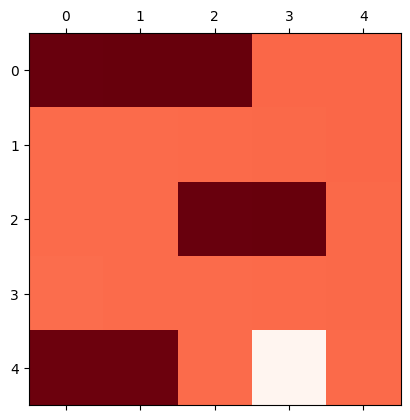

In [7]:
plt.matshow(ROI_1984_redband3.values[:5, :5], cmap="Reds_r")

>**B6.** (OPTIONAL) Extract and plot a numpy subarray of `ROI_1984_redband3` values as in **B5.** but this time annotate each pixel with it's (reflectance) value.
>```
array = ROI_1984_redband3.values[:5, :5]
fig, ax = plt.subplots(figsize=(5,5))    # Adjust the size to fit the subarray size and/or adjust the annotations in the `plt.text()` call
ax.matshow(array, cmap="Reds_r")
for y in range(array.shape[0]):
    for x in range(array.shape[1]):
        plt.text(x,y,array[y,x], bbox=dict(facecolor='beige'), horizontalalignment="center")
plt.show()
```

> <font color='blue'>**B6.** Alternative (OPTIONAL)</font> 
>```
array = ROI_1984_redband3[:5, :5]
fig, ax = plt.subplots(figsize=(5,5))    # Adjust the size to fit the subarray size and/or adjust the annotations in the `plt.text()` call
ax.matshow(array, cmap="Reds_r")
for y in range(array.shape[0]):
    for x in range(array.shape[1]):
        plt.text(x,y,array[y,x], bbox=dict(facecolor='beige'), horizontalalignment="center")
plt.show()
```

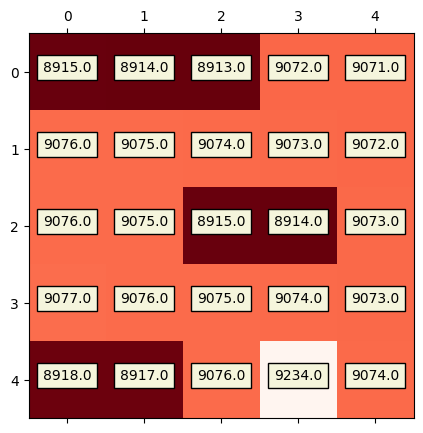

In [8]:
array = ROI_1984_redband3.values[:5, :5]
fig, ax = plt.subplots(figsize=(5,5))    # Adjust the size to fit the subarray size and/or adjust the annotations in the `plt.text()` call
ax.matshow(array, cmap="Reds_r")
for y in range(array.shape[0]):
    for x in range(array.shape[1]):
        plt.text(x,y,array[y,x], bbox=dict(facecolor='beige'), horizontalalignment="center")
plt.show()

>**B7.** As the area of the ROI in 1984 covered by the pixels in the top-left corner is not overly interesting (!), let's have a look at the top-right corner instead.    
> Start by visualising a 5x5 matrix, then keep increasing the size of the row/column slices, e.g. up to 500x500.
>```
plt.matshow(ROI_1984_redband3.values[:5, -5:], cmap="Reds_r")    # Use negative indices for ease
```

> <font color='blue'>**B7.** Alternative</font>
>```
plt.matshow(ROI_1984_redband3[:5, -5:], cmap="Reds_r")
```

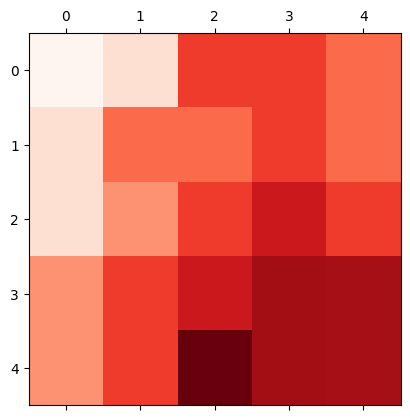

In [9]:
plt.matshow(ROI_1984_redband3.values[:5, -5:], cmap="Reds_r") 

<font color="green">***B7. Comment***     
*- NASA has a (legacy) collection of satellite image showcasing interesting Agricultural Patterns -> https://earthobservatory.nasa.gov/images/6605/agricultural-patterns*

---
## C. Prepare to calculate a spectral vegetation index

<font color="green">***C. Intro***    
*- A Spectral Index or Ratio is an indicator of some phenomena, such as biophysical or biochemical properties, calculated using the different reflectance properties of different objects.*    
*- Landsat data products like Burn Ratios and Moisture Index are examples of spectral indices.*    
*- One type of spectral indices relevant to Deforestation are Vegetation Indices (VI), the most common of which is the Normalized Difference Vegetation Index (NDVI), used to quantify vegetation greenness.*    

<font color="green">*- NDVI utilises certain reflectance properties of plants: chlorophyll strongly absorbs Red light, whilst leaves/plant structure strongly reflects NIR light.*      
*- The formula to calculate NDVI therefore requires the reflectance values in the Red and NIR bands:*

$$
  NDVI = \frac{(Near Infrared - Red)}{(Near Infrared + Red)}
$$      

<font color="green">*- By design, NDVI values therefore range from -1.0 to +1.0. Negative values to 0 indicate no green leaves, whilst values approaching +1.0 indicate highest density of green leaves. (See NASA NDVI training, slide 10-11 -> https://appliedsciences.nasa.gov/sites/default/files/2020-11/ndvipart1.pdf)*        
*- In Section D. we will calculate NDVI values for our ROI to help detect how the existing tropical dry forest cover in 1984 had changed by 2022, as likely Deforestation.*     
*- Note that NDVI is often a pre-calculated data product, and is available from the LandsatLook portal - however for learning purposes we will construct our own.*

>**C0.** In advance of calculating NDVI values using the above raster math formula, render the Red and NIR rasters of the ROI from 2022 as subplots.
>
>**Code Detail:** Use functionality provided by xarray via the `robust` parameter to compute plot colour limits excluding outliers, i.e. using the 2nd and 98th percentiles of the data -> https://docs.xarray.dev/en/stable/user-guide/plotting.html#robust
>```
fig, ax = plt.subplots(1,2, figsize=(14, 5))
ROI_2022_redband4.plot(cmap="Reds_r", ax=ax[0], robust=True)
ROI_2022_nirband5.plot(cmap="Blues_r", ax=ax[1], robust=True)
plt.show()
```

> <font color='blue'>**C0.** Alternative</font> 
```
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].matshow(ROI_1984_redband3, cmap="Reds_r")
ax[1].matshow(ROI_1984_nirband4, cmap="Blues_r")
plt.show()
```

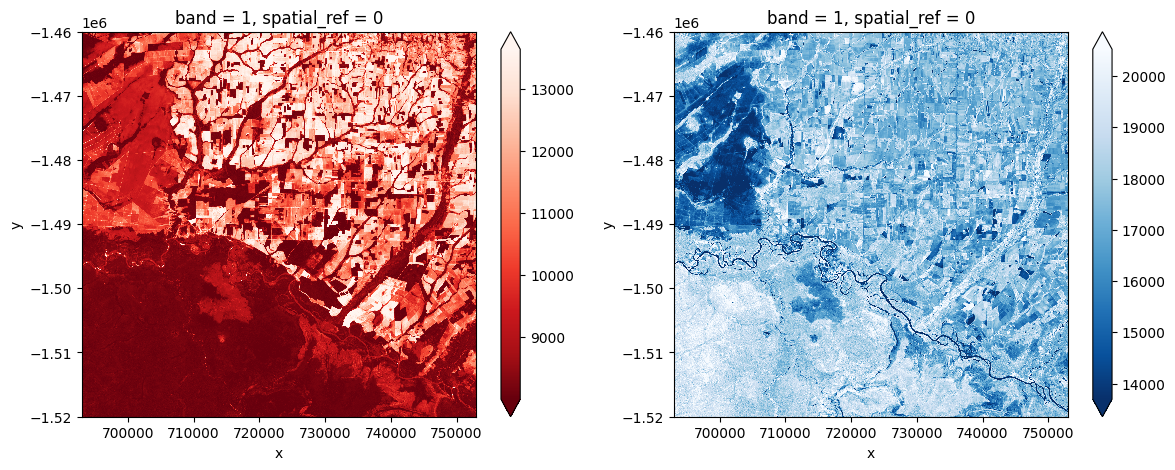

In [10]:
fig, ax = plt.subplots(1,2, figsize=(14, 5))
ROI_2022_redband4.plot(cmap="Reds_r", ax=ax[0], robust=True)
ROI_2022_nirband5.plot(cmap="Blues_r", ax=ax[1], robust=True)
plt.show()

---
## D. Calculate Normalized Difference Vegetation Index (NDVI)

>**D0.** / <font color="blue">**D0.** Alternative</font> Calculate NDVI values for the ROI in 1984 by performing the required raster math with `ROI_1984_nirband4` and `ROI_1984_redband3`, and assign to `NDVI_1984`.
>```
NDVI_1984 = (ROI_1984_nirband4 - ROI_1984_redband3) / (ROI_1984_nirband4 + ROI_1984_redband3)
```

In [11]:
NDVI_1984 = (ROI_1984_nirband4 - ROI_1984_redband3) / (ROI_1984_nirband4 + ROI_1984_redband3)

>**D1.** Sense-check some of the `NDVI_1984` values, must be between -1.0 and +1.0.
>```
NDVI_1984.values[:2, :2]
```

> <font color="blue">**D1.** Alternative</font>
>```
NDVI_1984[:2, :2]
```

In [12]:
NDVI_1984.values[:2, :2]

array([[0.35135332, 0.3471749 ],
       [0.35187632, 0.34355673]], dtype=float32)

>**D2.** / <font color="blue">**D2.** Alternative</font> Calculate NDVI values for the ROI in 2022 by performing the required raster math with `ROI_2022_nirband4` and `ROI_2022_redband3`, and assign to `NDVI_2022`.
>```
NDVI_2022 = (ROI_2022_nirband5 - ROI_2022_redband4) / (ROI_2022_nirband5 + ROI_2022_redband4)
```

In [13]:
NDVI_2022 = (ROI_2022_nirband5 - ROI_2022_redband4) / (ROI_2022_nirband5 + ROI_2022_redband4)

>**D3.** Also sense-check some of the `NDVI_2022` values.
>```
NDVI_2022.values[:2, :2]
```

> <font color="blue">**D3.** Alternative</font>
>```
NDVI_2022[:2, :2]
```

>**D4.** (OPTIONAL) Export NDVI rasters, which are xarray `DataArray` objects, in geotiff format.
>```
NDVI_1984.rio.to_raster("NDVI_1984.tif")
NDVI_2022.rio.to_raster("NDVI_2022.tif")
```

> <font color="blue">**D4.** Alternative (OPTIONAL)</font> Export NDVI arrays as binary files in numpy `.npy` format. Use `np.load()` to read.
>```
np.save("NDVI_1984", NDVI_1984)
np.save("NDVI_2022", NDVI_2022)
```

In [14]:
NDVI_1984.rio.to_raster("NDVI_1984.tif")
NDVI_2022.rio.to_raster("NDVI_2022.tif")

---
## E. Create & Interpret NDVI maps

>**E0.** The NDVI datasets are still geospatial rasters, i.e. grids of pixels, and still each linked to 30 square meters on Earth. However, the value of these pixels indicate the density of green leaves covering that place on Earth, on a scale of -1.0 to +1.0, (i.e. not measurements of spectral reflectance). Let's therefore render both NDVI rasters to help discover how dense vegetation was in our ROI in 1984 compared to 2022.

>**Code Detail:** Use manually pre-calculated `vmin` and `vmax` args to scale the (false) color to the actual range of our NDVI values.
>```
fig, ax = plt.subplots(1,2, figsize=(14, 5))
NDVI_1984.plot(cmap="terrain_r", ax=ax[0], vmin=-0.15, vmax=0.75)
NDVI_2022.plot(cmap="terrain_r", ax=ax[1], vmin=-0.15, vmax=0.75)
plt.show()
```

> <font color="blue">**E0.** Alternative</font>
>```
fig, ax  = plt.subplots(1,2, figsize=(14,5))
plot0 = ax[0].matshow(NDVI_1984, cmap="terrain_r", vmin=-0.15, vmax=0.75)
fig.colorbar(plot0, ax=ax[0])
plot1 =ax[1].matshow(NDVI_2022, cmap="terrain_r", vmin=-0.15, vmax=0.75)
fig.colorbar(plot1, ax=ax[1])
plt.show()
```

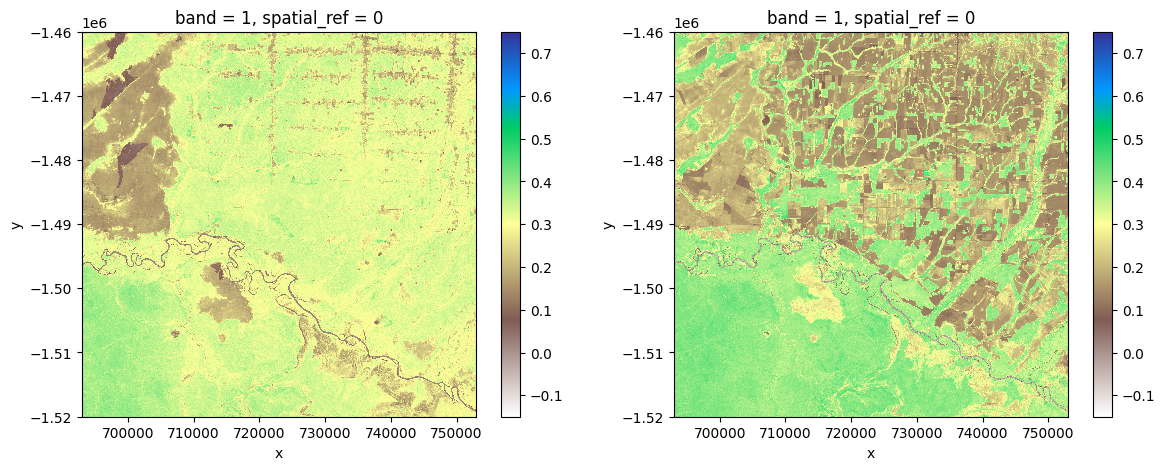

In [15]:
fig, ax = plt.subplots(1,2, figsize=(14, 5))
NDVI_1984.plot(cmap="terrain_r", ax=ax[0], vmin=-0.15, vmax=0.75)
NDVI_2022.plot(cmap="terrain_r", ax=ax[1], vmin=-0.15, vmax=0.75)
plt.show()


<font color="green">***E0. Comments***    
*- **CAVEAT REMINDER!!** The difference in Landsat 5 TM and Landsat 9 OLI's band coverage affects the comparability of the respective NDVI computed, as derivative data products.*    
*- However, these NDVI maps do provide guidance about the potential LCLU in this Amazon River basin region in 1984 and 2022:*    
 
*"Areas of barren rock, sand, or snow usually show very low NDVI values (for example, 0.1 or less). Sparse vegetation such as shrubs and grasslands or senescing crops may result in moderate NDVI values (approximately 0.2 to 0.5). High NDVI values (approximately 0.6 to 0.9) correspond to dense vegetation such as that found in temperate and tropical forests or crops at their peak growth stage."* (https://www.usgs.gov/special-topics/remote-sensing-phenology/science/ndvi-foundation-remote-sensing-phenology)

<font color="green">*- Other Remote Sensing considerations: Controlling for satellite band designations, spectral reflectance and therefore also derived products like spectral indices, are sensitive to different angles of observation and differences in the atmostphere during the two satellite overpasses, amongst many other factors.*

>**E1.** So far in this Exploration we've been handling continuous raster data. However, in preparation for developing a thematic Land Cover map next section, let's start to consider how we could meaningfully group, or bin, pixels into NDVI ranges associated with specific land cover. Check the distribution of both sets of NDVI values through quick histogram plotting. 
>```
NDVI_1984.plot.hist(color="royalblue")
NDVI_2022.plot.hist(color="m", alpha=0.5);    # The semi-colon tidies the plot by suppresses some extraneous info
```

> <font color="blue">**E1.** Alternative</font> 
>```
plt.figure()
plt.hist(NDVI_1984.flatten(), color="royalblue")
plt.hist(NDVI_2022.flatten(), color="m", alpha=0.5);
```

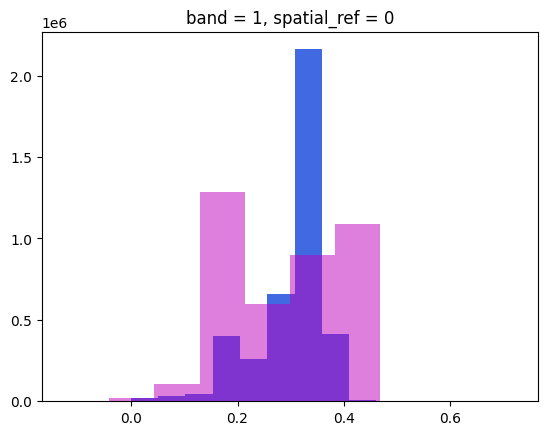

In [16]:
NDVI_1984.plot.hist(color="royalblue")
NDVI_2022.plot.hist(color="m", alpha=0.5); 

---
## F. Classify Land Cover using NDVI & make thematic map

<font color="green">***F. Intro***    
*- LEARNING NOTE: This section is designed to **introduce** the idea of pixel-based Image Classification of Land Cover using Satellite Imagery in order to create thematic maps, and **does not represent best-practice**! Check out NASA training material on this topic, e.g. -> https://appliedsciences.nasa.gov/sites/default/files/Session%20One%20-%20Introduction%20to%20Land%20Cover%20Classification%20and%20QGIS.pdf*      
*- We will be executing an experimental process, trying to develop a meaningful thematic Land Cover map of our ROI in 2022, leveraging known NDVI values of certain land cover, and the distribution of empirical NDVI values.*      
*- Central to this process is performing pixel-based classification. We will have a go at producing a map that describes 4 land cover types, by implementing the below experimental classification scheme whereby every pixel will be assigned a class, based on it's NDVI value:*

> 
|       Class                   | NDVI   | 
| ----------------------------- | ------ |
| Rock/Bare Soil/Water/Concrete | -1.0 <= NDVI < 0.15 |
| Sparse/Senescing Veg1         | 0.15 <= NDVI < 0.25 |
| Sparse/Senescing Veg2         | 0.25 <= NDVI < 0.4  |
| Denser Veg                    | 0.4  <= NDVI <= 1.0 |
>


>**F0.** / <font color='blue'>**F0.** No Alternative</font> Find out the official type of the `NDVI_2022` object.
>```
type(NDVI_2022)
```

>**F1.** / <font color='blue'>**F1.** Alternative</font> Make a copy of `NDVI_2022` named `LCLU`.
>```
LCLU = NDVI_2022.copy()
```

In [17]:
LCLU = NDVI_2022.copy()

>**F2.** Our approach to implementing the pixel classification involves manually binning the subset of pixels that belong in each class (so the process is more transparent).  Try calling xarray's `where()` function in order to test replacing the NDVI values in `LCLU` which are `< 0.3` with `99`.
>```
xr.where(LCLU < 0.3, 99, LCLU)
```

> <font color="blue">**F2.** Alternative</font>
>```
np.where(LCLU < 0.3, 99, LCLU)
```

>**F3.** Build the final `DataArray` output, `LCLU_4`, through creating a series of incrementally updated `DataArrays`, that replace the pixel values assigned to each class with `100`, `200`, `300`, and `400` respectively.
>
>**Tech Note:**    
>1.0 <= NDVI <0.15 becomes 100 - Rock/Bare Soil/Water/Concrete class    
>0.15 <= NDVI <0.25 becomes 200 - Sparse/Senescing Veg1 class    
>0.25 <= NDVI <0.4 becomes 300 - Sparse/Senescing Veg2 class     
>0.4 <= NDVI <=1.0 becomes 400 - Denser Veg  class    
>```
LCLU_1 = xr.where(LCLU < 0.15, 100, LCLU)
LCLU_2 = xr.where(LCLU_1 < 0.25, 200, LCLU_1)
LCLU_3 = xr.where(LCLU_2 < 0.4, 300, LCLU_2)
LCLU_4 = xr.where(LCLU_3 <= 1, 400, LCLU_3)
```

> <font color="blue">**F3.** Alternative</font> 
>```
LCLU_1 = np.where(LCLU < 0.15, 100, LCLU)
LCLU_2 = np.where(LCLU_1 < 0.25, 200, LCLU_1)
LCLU_3 = np.where(LCLU_2 < 0.4, 300, LCLU_2)
LCLU_4 = np.where(LCLU_3 <= 1, 400, LCLU_3)
```

In [18]:
LCLU_1 = xr.where(LCLU < 0.15, 100, LCLU)
LCLU_2 = xr.where(LCLU_1 < 0.25, 200, LCLU_1)
LCLU_3 = xr.where(LCLU_2 < 0.4, 300, LCLU_2)
LCLU_4 = xr.where(LCLU_3 <= 1, 400, LCLU_3)

>**F4.** Review the fully classified raster `LCLU_4`, representing our Land Cover map, by generating a quick plot.
>```
LCLU_4.plot()
```

> <font color="blue">**F4.** Alternative</font> 
>```
LCLU_4_plot = plt.matshow(LCLU_4)
fig.colorbar(LCLU_4_plot)
plt.show()
```

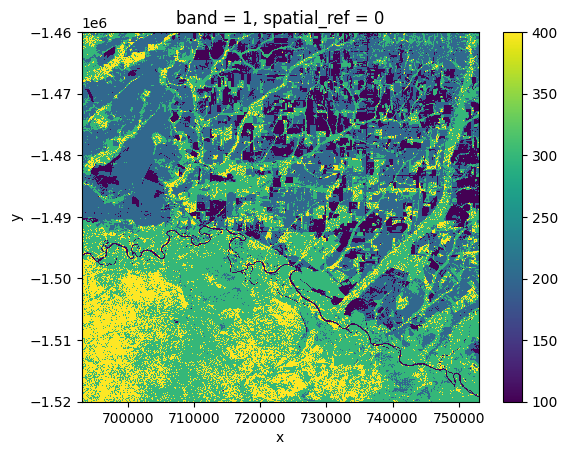

In [19]:
LCLU_4.plot()

>**F5.** / <font color="blue">**F5.** Alternative</font> Let's prepare to construct an upgraded version of this Land Cover map. Import the `ListedColormap` class from matplotlib.colors.
>```
from matplotlib.colors import ListedColormap
```

In [20]:
from matplotlib.colors import ListedColormap

>**F6.** / <font color="blue">**F6.** Alternative</font> Create a custom cmap consisting of 4 appropriate named colours called `LCLU_cmap`. The colours will be used in turn, starting from the lowest data values then ascending, i.e. 100 to 400.
```
LCLU_cmap = ListedColormap( ["sandybrown", "gold", "yellowgreen", "forestgreen"] )
```

In [21]:
LCLU_cmap = ListedColormap( ["sandybrown", "gold", "yellowgreen", "forestgreen"] )

>**F7.** Make the upgraded Land Cover map of the ROI from 2022, using `LCLU_cmap` and other matplotlib options to fine-tune the plot.
>```
fig, ax = plt.subplots(figsize=(8,6))
LCLU_4.plot(cmap=LCLU_cmap)
colorbar=ax.collections[0].colorbar
colorbar.set_ticks([100,200,300,400])
colorbar.set_ticklabels(["Rock/Bare Soil/Water/Concrete", "Sparse/Senescing Veg1", "Sparse/Senescing Veg2", "Denser Veg"])
#plt.tight_layout()
#plt.savefig("<SomeFilename>.png", dpi=600)    # Use the optional dpi (dots-per-inch) argument to control the resolution of the png
plt.show()
```

> <font color="blue">**F7.** Alternative</font>
>```
fig, ax = plt.subplots(figsize=(8,6))
classed_plot = ax.matshow(LCLU_4, cmap=LCLU_cmap)
cbar = fig.colorbar(classed_plot)
cbar.set_ticks([100,200,300,400])
cbar.set_ticklabels(["Rock/Bare Soil/Water/Concrete", "Sparse/Senescing Veg1", "Sparse/Senescing Veg2", "Denser Veg"])
#plt.tight_layout()
#plt.savefig("<SomeFilename>.png", dpi=600)
plt.show()
```

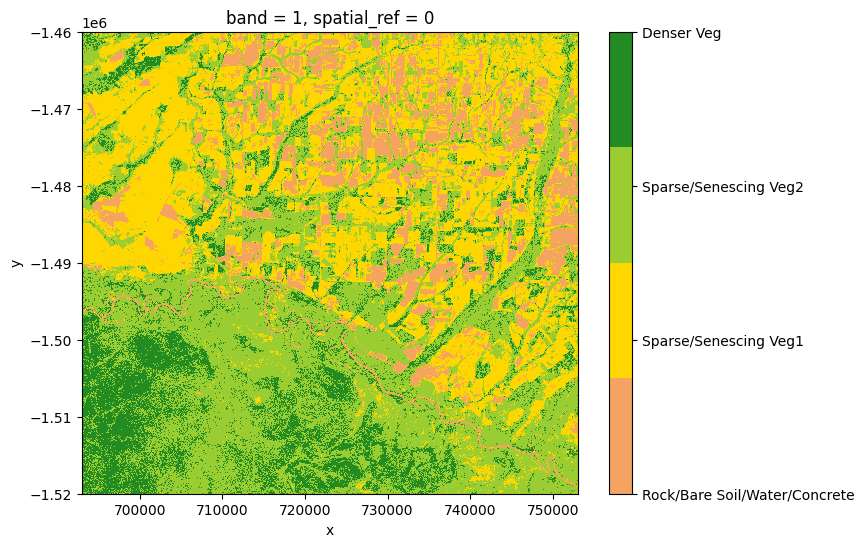

In [22]:
fig, ax = plt.subplots(figsize=(8,6))
LCLU_4.plot(cmap=LCLU_cmap)
colorbar=ax.collections[0].colorbar
colorbar.set_ticks([100,200,300,400])
colorbar.set_ticklabels(["Rock/Bare Soil/Water/Concrete", "Sparse/Senescing Veg1", "Sparse/Senescing Veg2", "Denser Veg"])
#plt.tight_layout()
#plt.savefig("<SomeFilename>.png", dpi=600)    # Use the optional dpi (dots-per-inch) argument to control the resolution of the png
plt.show()

---
## G. Transform coordinates from different map projection (OPTIONAL)
<font color='blue'>**G.** No Alternative</font>

<font color="green">***G. Intro***     
*- We briefly mentioned map projection and CRS in the Carbon Polluters Exploration.*    
*- This section works through a real use-case for navigating different projections in order to be able to cross-reference places on earth between different maps/sources.*    
*- Having identified a point of interest (POI) using "The Brazilian Annual Land Use and Land Cover Mapping Project" (MapBiomas) where forest has been cleared for pasture in 2020, we will take steps to extend the F7. Land Cover map with an annotation of this POI.*    
           
     
* (OPTIONAL) Steps taken to identify POI:    
    * Access MapBiomas at https://mapbiomas.org/
    * MAPAS E DADOS > ACESSE A PLATAFORMA > PLATAFORMA MAPBIOMAS USO E COBERTURA
    * For English, change setting at bottom-left 
    * Under Land Cover default view, set Territory Category as State and Territory as Rondônia
    * Under Legend click Natural and Anthropic use
    * Deselect the Anthropic option, then select just the Pasture sub-use
    * Zoom to the POI at map coordinates (-13.55, -61.00) and use the horizontal time slider to compare change from Natural to Pasture use from 2020 to 2021

>**G0.** Load specific functionality from pyproj.
>```
from pyproj import Transformer, CRS
```

In [23]:
from pyproj import Transformer, CRS

>**G1.** Check `NDVI_2022`'s projection.
>```
NDVI_2022.rio.crs
```

In [24]:
NDVI_2022.rio.crs

CRS.from_epsg(32620)

>**G2.** Use `CRS` to find out official info about the crs EPSG:32620.
>```
CRS.from_epsg(32620)
```

>**G3.** Create variables for the POI coordinates, `-13.55, -61.00` (lat, long), which are in the EPSG:4326 coordinate system.
>```
epsg4326_long = -61.00
epsg4326_lat = -13.55
```

In [25]:
epsg4326_long = -61.00
epsg4326_lat = -13.55

>**G4.** Prepare to convert/transform these EPSG:4326 coordinates to the CRS our raster data is in, EPSG:32620. First create the Transformer object.
>```
transformer_4326to32620 = Transformer.from_crs("EPSG:4326", NDVI_2022.rio.crs, always_xy=True)
```

In [26]:
transformer_4326to32620 = Transformer.from_crs("EPSG:4326", NDVI_2022.rio.crs, always_xy=True)

>**G5.** Use the Transformer object to convert the EPSG:4326 coordinates to the EPSG:32620 CRS as `epsg32620_POI_x` and `epsg32620_POI_y`.    
>
>**Tech Note:** (x,y) refers to (long,lat).
>```
epsg32620_POI_x, epsg32620_POI_y = transformer_4326to32620.transform(epsg4326_long, epsg4326_lat)
```

In [27]:
epsg32620_POI_x, epsg32620_POI_y = transformer_4326to32620.transform(epsg4326_long, epsg4326_lat)

>**G6.** Have a look at the actual converted coordinates of our POI.
>```
epsg32620_POI_x, epsg32620_POI_y
```

In [28]:
epsg32620_POI_x, epsg32620_POI_y

(716434.5923468311, -1498844.760850347)

>**G7.** Try using the converted POI coordinates with xarray's `sel()` method to see what the NDVI value in 2022 was at this location.
>```
NDVI_2022.sel(x=epsg32620_POI_x, y=epsg32620_POI_y, method="nearest").values
```

In [29]:
NDVI_2022.sel(x=epsg32620_POI_x, y=epsg32620_POI_y, method="nearest").values

array(0.38458243, dtype=float32)

>**G8.** Copy the **F7.** plotting routine, add an `annotate()` call to mark the POI on the classified `LCLU_4` raster, and resize the plot.
>```
fig, ax = plt.subplots(figsize=(11,8))
LCLU_4.plot(cmap=LCLU_cmap)
colorbar=ax.collections[0].colorbar
colorbar.set_ticks([100,200,300,400])
colorbar.set_ticklabels(["Rock/Bare Soil/Water/Concrete", "Sparse/Senescing Veg1", "Sparse/Senescing Veg2", "Denser Veg"])
ax.annotate("New deforestation for pasture", xy=(epsg32620_POI_x, epsg32620_POI_y), arrowprops=dict(facecolor="Red"), textcoords="axes fraction", xytext = (0.5, 0.15), fontsize=12)
#plt.tight_layout()
#plt.savefig("<SomeFilename>.png", dpi=600)    
plt.show()
```

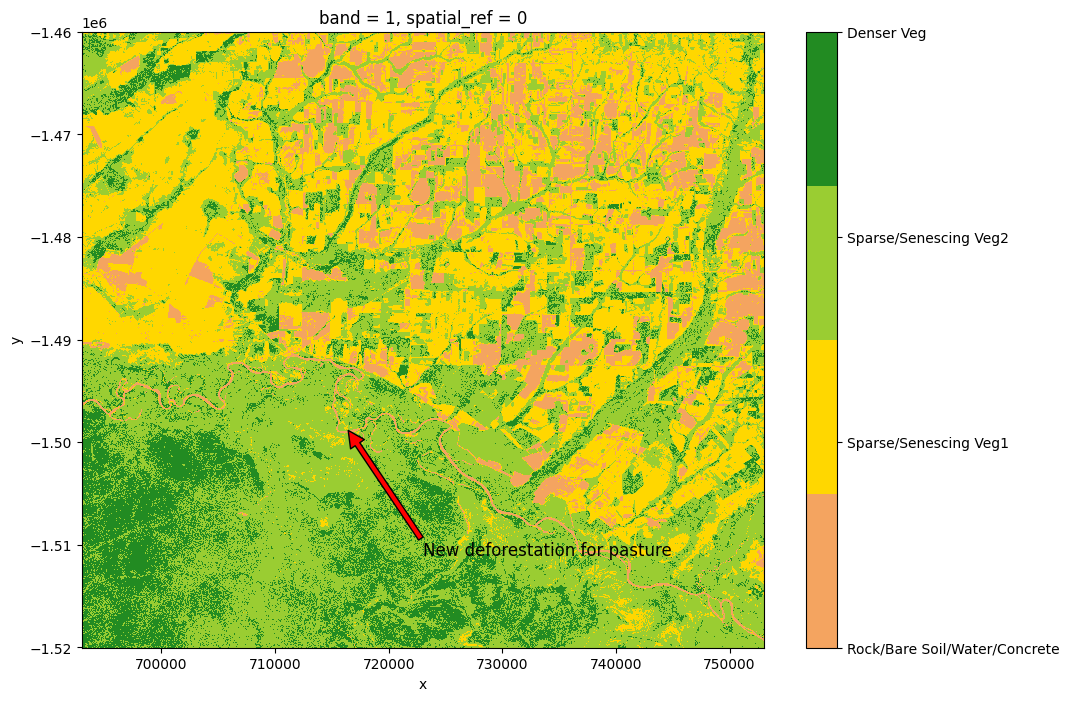

In [30]:
fig, ax = plt.subplots(figsize=(11,8))
LCLU_4.plot(cmap=LCLU_cmap)
colorbar=ax.collections[0].colorbar
colorbar.set_ticks([100,200,300,400])
colorbar.set_ticklabels(["Rock/Bare Soil/Water/Concrete", "Sparse/Senescing Veg1", "Sparse/Senescing Veg2", "Denser Veg"])
ax.annotate("New deforestation for pasture", xy=(epsg32620_POI_x, epsg32620_POI_y), arrowprops=dict(facecolor="Red"), textcoords="axes fraction", xytext = (0.5, 0.15), fontsize=12)
#plt.tight_layout()
#plt.savefig("<SomeFilename>.png", dpi=600)    
plt.show()